Round 1: 
Start: 24/05/2021
End: 26/07/2021

Round 2:
Start: 15/11/2021
End: 17/01/2022

# User Engagement

In [143]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import json
from bson import ObjectId
from pprint import pprint
import streamlit as st
import seaborn as sns
import pickle
import ast

In [144]:
#sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})  
#sns.set(font_scale=1.3)
#plt.rcParams['xtick.major.size'] = 4
#plt.rcParams['xtick.major.width'] = 4
#plt.rcParams['xtick.bottom'] = True
#plt.rcParams['ytick.left'] = True
#sns.set_style('ticks')
sns.set_palette(palette='Dark2')

In [145]:
with open('credentials.json') as f:
    data = json.load(f)
    username = data['username']
    password = data['password']

In [146]:
client = MongoClient('mongodb://%s:%s@127.0.0.1' % (username, password))
db = client.raisv2

# SEMA

# 1) Context and Mood Survey

In [147]:
collection = db.sema
df = pd.DataFrame(list(collection.find()))

In [148]:
# Deleting the no-responses and nones
df=pd.DataFrame(list(collection.find( { '$and': [ {"data.MOOD": { "$ne": "<no-response>" }},{"data.MOOD": { "$ne": None }}, {"data.PLACE": { "$ne": "<no-response>" }},{"data.PLACE": { "$ne": None }} ] } )))

In [149]:
df=df[['user_id']].join(pd.DataFrame(df['data'].tolist(), index=df.index).add_prefix('data.'))

In [150]:
df['Dates'] = pd.to_datetime(df['data.CREATED_TS']).dt.date
df['Time'] = pd.to_datetime(df['data.CREATED_TS']).dt.time
users=df['user_id']
days=df['Dates']
place=df['data.PLACE']
mood=df['data.MOOD']
df = pd.concat([users, days, place, mood],axis=1)
df = df.sort_values(by='Dates', ascending=True)
df['Dates'] = pd.to_datetime(df['Dates'].astype("str"), format='%Y-%m-%d')

In [151]:
df2 = df.groupby('Dates')['user_id'].nunique()
df2 =pd.DataFrame(df2)
df2 = df2.rename(columns={'user_id': 'Number of participants'})

In [152]:
df2.reset_index(inplace=True)
# Separating the two rounds
df2['Dates'] = pd.to_datetime(df2['Dates']) 
round1 = (df2['Dates'] >= "2021-05-24") & (df2['Dates'] <= "2021-07-26")
round1=df2.loc[round1]

df2['Dates'] = pd.to_datetime(df2['Dates']) 
round2 = (df2['Dates'] >= "2021-11-15") & (df2['Dates'] <= "2022-01-17")
round2=df2.loc[round2]

# SEMA

# 2) Step Goals Survey

In [153]:
collection = db.sema
step_goal = pd.DataFrame(list(collection.find()))

In [154]:
# Deleting the no-responses and nones
step_goal=pd.DataFrame(list(collection.find( { '$and': [{"data.STEPS": { "$ne": "<no-response>" }},{"data.STEPS": { "$ne": None }} ] } )))

In [155]:
step_goal=step_goal[['user_id']].join(pd.DataFrame(step_goal['data'].tolist(), index=step_goal.index).add_prefix('data.'))

In [156]:
step_goal['Dates'] = pd.to_datetime(step_goal['data.CREATED_TS']).dt.date
step_goal['Time'] = pd.to_datetime(step_goal['data.CREATED_TS']).dt.time
users=step_goal['user_id']
days=step_goal['Dates']
steps=step_goal['data.STEPS']
step_goal = pd.concat([users, days, steps],axis=1)
step_goal = step_goal.sort_values(by='Dates', ascending=True)
step_goal['Dates'] = pd.to_datetime(step_goal['Dates'].astype("str"), format='%Y-%m-%d')
step_goal.head()

,user_id,Dates,data.STEPS
735,621e362467b776a2404ad513,2021-04-08,14999
1662,621e362467b776a2404ad513,2021-04-08,14999
384,621e362467b776a2404ad513,2021-04-09,7999
273,621e362467b776a2404ad513,2021-04-09,9999
218,621e362467b776a2404ad513,2021-04-10,19999


In [157]:
step_goal = step_goal.groupby('Dates')['user_id'].nunique()
step_goal =pd.DataFrame(step_goal)
step_goal = step_goal.rename(columns={'user_id': 'Number of participants'})
step_goal.head()

,Number of participants
Dates,
2021-04-08,1
2021-04-09,1
2021-04-10,1
2021-04-12,1
2021-04-13,1


In [158]:
step_goal.reset_index(inplace=True)
step_goal['Dates'] = pd.to_datetime(step_goal['Dates']) 
step_goal_round1 = (step_goal['Dates'] >= "2021-05-24") & (step_goal['Dates'] <= "2021-07-26")
step_goal_round1=step_goal.loc[step_goal_round1]


step_goal['Dates'] = pd.to_datetime(step_goal['Dates']) 
step_goal_round2 = (step_goal['Dates'] >= "2021-11-15") & (step_goal['Dates'] <= "2022-01-17")
step_goal_round2=step_goal.loc[step_goal_round2]

# Fitbit synced data (wear-days)

In [159]:
# Loading the data of daily user steps

infile = open('data/users_steps_daily','rb')
steps_daily = pickle.load(infile)
infile.close()

steps_daily.head() 

,date,steps,id
0,2015-09-22,5123,621e314867b776a24029ebf9
1,2015-09-23,10691,621e314867b776a24029ebf9
2,2015-09-24,10462,621e314867b776a24029ebf9
3,2015-09-25,7052,621e314867b776a24029ebf9
4,2015-09-26,13993,621e314867b776a24029ebf9


In [160]:
# deleting the <500 values of steps
steps_daily = steps_daily[steps_daily.steps >= 500] # actual wear-days

In [161]:
steps_daily = steps_daily.sort_values(by='date', ascending=True)
steps_daily.head()

,date,steps,id
0,2015-09-22,5123,621e314867b776a24029ebf9
1,2015-09-23,10691,621e314867b776a24029ebf9
2,2015-09-24,10462,621e314867b776a24029ebf9
3,2015-09-25,7052,621e314867b776a24029ebf9
4,2015-09-26,13993,621e314867b776a24029ebf9


In [162]:
dict = {'date': 'Dates','id':'user_id'}
 
steps_daily.rename(columns=dict,inplace=True)
steps_daily

,Dates,steps,user_id
0,2015-09-22,5123,621e314867b776a24029ebf9
1,2015-09-23,10691,621e314867b776a24029ebf9
2,2015-09-24,10462,621e314867b776a24029ebf9
3,2015-09-25,7052,621e314867b776a24029ebf9
4,2015-09-26,13993,621e314867b776a24029ebf9
...,...,...,...
9168,2022-02-09,15689,621e2eaf67b776a2406b14ac
9171,2022-02-10,3632,621e340467b776a2402d7982
9172,2022-02-10,10347,621e2eaf67b776a2406b14ac
9170,2022-02-10,5366,621e346f67b776a24081744f


In [163]:
steps_daily.reset_index(inplace=True)
steps_daily= steps_daily.groupby('Dates')['user_id'].nunique()
steps_daily =pd.DataFrame(steps_daily)
steps_daily = steps_daily.rename(columns={'user_id': 'Number of participants'})
steps_daily

,Number of participants
Dates,
2015-09-22,1
2015-09-23,1
2015-09-24,1
2015-09-25,1
2015-09-26,1
...,...
2022-02-07,4
2022-02-08,3
2022-02-09,2


In [164]:
#Separating the two Rounds
steps_daily.reset_index(inplace=True)
steps_daily['Dates'] = pd.to_datetime(steps_daily['Dates']) 
steps_daily_round1 = (steps_daily['Dates'] >= "2021-05-24") & (steps_daily['Dates'] <= "2021-07-26")
steps_daily_round1=steps_daily.loc[steps_daily_round1]


steps_daily['Dates'] = pd.to_datetime(steps_daily['Dates']) 
steps_daily_round2 = (steps_daily['Dates'] >= "2021-11-24") & (steps_daily['Dates'] <= "2022-01-17")
steps_daily_round2=steps_daily.loc[steps_daily_round2]

# Surveys completed over time

In [165]:
collection = db.surveys
surveys = pd.DataFrame(list(collection.find()))
surveys.head()

,_id,user_id,type,data
0,6241bd11a59be121689b2aff,621e36f967b776a240e5e7c9,breq,"{'id': 1, 'submitdate': '31/5/2021 12:42', 'la..."
1,6241bd11a59be121689b2b00,621e32af67b776a24045b4cf,breq,"{'id': 2, 'submitdate': '31/5/2021 13:24', 'la..."
2,6241bd11a59be121689b2b01,621e335a67b776a240bb12ff,breq,"{'id': 3, 'submitdate': '31/5/2021 13:32', 'la..."
3,6241bd11a59be121689b2b02,621e2fce67b776a240279baa,breq,"{'id': 4, 'submitdate': '31/5/2021 13:32', 'la..."
4,6241bd11a59be121689b2b03,621e341067b776a24037b105,breq,"{'id': 5, 'submitdate': '31/5/2021 13:33', 'la..."


In [166]:
surveys=surveys[['user_id']].join(pd.DataFrame(surveys['data'].tolist(), index=surveys.index).add_prefix('data.'))

In [167]:
surveys['Dates'] = pd.to_datetime(surveys['data.datestamp']).dt.date
surveys['Time'] = pd.to_datetime(surveys['data.datestamp']).dt.time
users=surveys['user_id']
days=surveys['Dates']
surveys = pd.concat([users, days],axis=1)
surveys = surveys.sort_values(by='Dates', ascending=True)
surveys['Dates'] = pd.to_datetime(surveys['Dates'].astype("str"), format='%Y-%m-%d')
surveys

,user_id,Dates
556,621e2f6167b776a240e082a9,2021-01-06
178,621e301367b776a24057738e,2021-01-06
177,621e2f6167b776a240e082a9,2021-01-06
176,621e375b67b776a240290cdc,2021-01-06
365,621e375b67b776a240290cdc,2021-01-06
...,...,...
708,621e346f67b776a24081744f,NaT
709,621e2eaf67b776a2406b14ac,NaT
710,621e333967b776a240a3cd06,NaT
711,621e375367b776a24021e950,NaT


In [168]:
surveys= surveys.groupby('Dates')['user_id'].nunique()
surveys =pd.DataFrame(surveys)
surveys = surveys.rename(columns={'user_id': 'Number of participants'})
surveys

,Number of participants
Dates,
2021-01-06,3
2021-01-07,1
2021-01-08,3
2021-01-12,1
2021-02-06,4
...,...
2022-07-01,2
2022-09-01,2
2022-10-01,8


In [169]:
#Separating the two rounds
surveys.reset_index(inplace=True)
surveys['Dates'] = pd.to_datetime(surveys['Dates']) 
surveys_round1 = (surveys['Dates'] >= "2021-05-24") & (surveys['Dates'] <= "2021-07-26")
surveys_round1=surveys.loc[surveys_round1]


surveys['Dates'] = pd.to_datetime(surveys['Dates']) 
surveys_round2 = (surveys['Dates'] >= "2021-11-15") & (surveys['Dates'] <= "2022-01-17")
surveys_round2=surveys.loc[surveys_round2]

In [170]:
file = open(r'data\round1_fitbit','rb')
df1 = pickle.load(file)
file.close()
df1

,Dates,Time,NumberOfDistictUsers
14771,2021-05-24,00:00:00,28
14772,2021-05-24,01:00:00,25
14773,2021-05-24,02:00:00,27
14774,2021-05-24,03:00:00,28
14775,2021-05-24,04:00:00,30
...,...,...,...
16302,2021-07-26,19:00:00,16
16303,2021-07-26,20:00:00,15
16304,2021-07-26,21:00:00,13
16305,2021-07-26,22:00:00,16


In [171]:
file = open(r'data\round2_fitbit','rb')
df2 = pickle.load(file)
file.close()
df2

,Dates,Time,NumberOfDistictUsers
18951,2021-11-15,00:00:00,16
18952,2021-11-15,01:00:00,14
18953,2021-11-15,02:00:00,16
18954,2021-11-15,03:00:00,15
18955,2021-11-15,04:00:00,15
...,...,...,...
20482,2022-01-17,19:00:00,11
20483,2022-01-17,20:00:00,10
20484,2022-01-17,21:00:00,9
20485,2022-01-17,22:00:00,7


2022-07-12 11:37:05.227 WARNING matplotlib.backends.backend_ps: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2022-07-12 11:37:05.228 WARNING matplotlib.backends.backend_ps: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


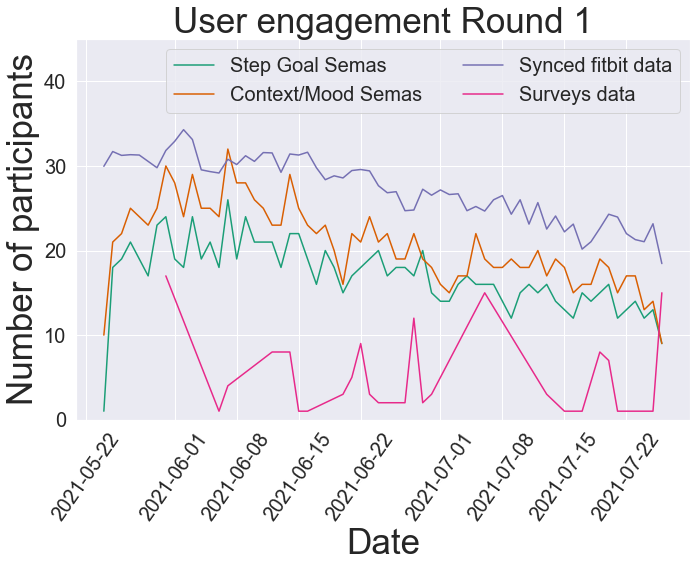

In [180]:
fig, ax = plt.subplots(figsize = (11, 7))
sns.set_palette(palette='Dark2')
ax = sns.lineplot(data=step_goal_round1, x="Dates", y="Number of participants", label='Step Goal Semas')
#ax = sns.scatterplot(data=step_goal_round1, x="Dates", y="Number of participants")
ax = sns.lineplot(data=round1, x="Dates", y="Number of participants", ax=ax, label='Context/Mood Semas')
#ax = sns.scatterplot(data=round1, x="Dates", y="Number of participants")
ax = sns.lineplot(data=df1, x="Dates", y="NumberOfDistictUsers", ax=ax, label='Synced fitbit data', ci=None)
#ax = sns.scatterplot(data=df1, x="Dates", y="NumberOfDistictUsers")
#ax = sns.lineplot(data=steps_daily_round1, x="Dates", y="Number of participants", ax=ax, label='Synced fitbit data')
#ax = sns.scatterplot(data=steps_daily_round1, x="Dates", y="Number of participants")
ax = sns.lineplot(data=surveys_round1, x="Dates", y="Number of participants", ax=ax, label='Surveys data')
#ax = sns.scatterplot(data=surveys_round1, x="Dates", y="Number of participants")
#ax = step_goal_round1.plot(x ='Dates', y='Number of participants', kind = 'line', color='red', style='-o', label='Step Goal Sema Surveys')
#ax = round1.plot(x ='Dates', y='Number of participants', kind = 'line', color='black', style='-o', ax=ax, label='Context and Mood Sema Surveys')
#ax = steps_daily_round1.plot(x ='Dates', y='Number of participants', kind = 'line', color='blue', style='-o', ax=ax, label='Synced fitbit data') 
#ax = surveys_round1.plot(x = 'Dates', y='Number of participants', kind='line',color='green',style='-o',ax=ax,label='Surveys data')
plt.xlabel('Date',fontsize=35)
plt.ylabel('Number of participants',fontsize=35)
plt.title('User engagement Round 1',fontsize=35)
#plt.legend(loc='lower left', bbox_to_anchor=(0.6, 0.68))
#plt.legend(fontsize=10)
plt.legend(ncol=2, loc="upper right",fontsize=20)
plt.xticks(rotation = 55)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0, 45)
plt.savefig("visualizations\Round-1-user-engagement.eps",bbox_inches='tight') 
plt.savefig("visualizations\Round-1-user-engagement.png",bbox_inches='tight') 
plt.show()

2022-07-12 11:37:06.209 WARNING matplotlib.backends.backend_ps: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2022-07-12 11:37:06.210 WARNING matplotlib.backends.backend_ps: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


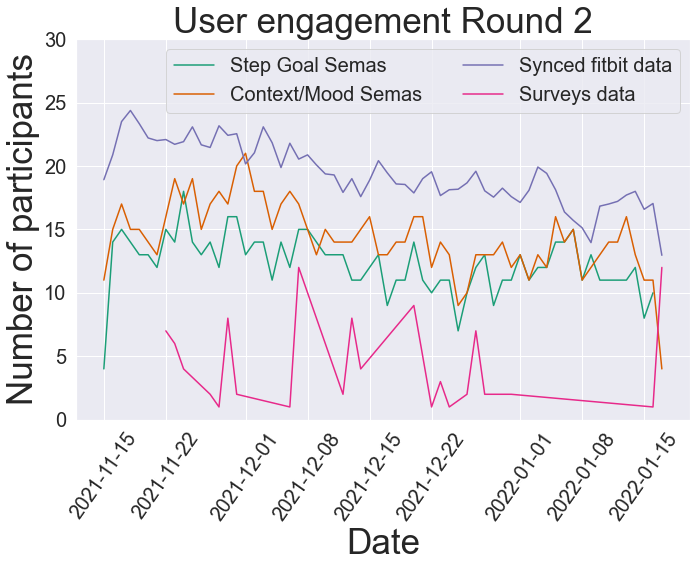

In [181]:
fig, ax = plt.subplots(figsize = (11, 7))
sns.set_palette(palette='Dark2')
ax = sns.lineplot(data=step_goal_round2, x="Dates", y="Number of participants", label='Step Goal Semas')
#ax = sns.scatterplot(data=step_goal_round2, x="Dates", y="Number of participants")
ax = sns.lineplot(data=round2, x="Dates", y="Number of participants", ax=ax, label='Context/Mood Semas')
#ax = sns.scatterplot(data=round2, x="Dates", y="Number of participants")
ax = sns.lineplot(data=df2, x="Dates", y="NumberOfDistictUsers", ax=ax, label='Synced fitbit data', ci=None)
#ax = sns.scatterplot(data=df2, x="Dates", y="NumberOfDistictUsers")
#ax = sns.lineplot(data=steps_daily_round2, x="Dates", y="Number of participants", ax=ax, label='Synced fitbit data')
#ax = sns.scatterplot(data=steps_daily_round2, x="Dates", y="Number of participants")
ax = sns.lineplot(data=surveys_round2, x="Dates", y="Number of participants", ax=ax, label='Surveys data')
#ax = sns.scatterplot(data=surveys_round2, x="Dates", y="Number of participants")
plt.xlabel('Date',fontsize=35)
plt.ylabel('Number of participants',fontsize=35)
plt.title('User engagement Round 2',fontsize=35)
plt.legend(ncol=2, loc="upper right",fontsize=20)
plt.xticks(rotation = 55,fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0, 30)
plt.savefig("visualizations\Round-2-user-engagement.eps",bbox_inches='tight') 
plt.savefig("visualizations\Round-2-user-engagement.png",bbox_inches='tight') 
plt.show()